<a href="https://colab.research.google.com/github/ASi-F/Sentiment-Analysis/blob/main/FFnnipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed Forward Neural Network
This is a sentiment classification model made using a feed forward neural network with 3 hidden layers and 500 neurons in each layer. The model is trained on the IMDB dataset consisting of 50000 reviews labelled as positive or negative. The dataset was divided into training, validation and testing datasets in 70-15-15 ratio. The accuracy is expressed as the empirical error on the test dataset. The model was optimized over various batchsizes and learning rates but the final accuracy showed little variation. 

In [1]:
import pandas as pd
import os
import torch
import numpy as np
import nltk
import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [3]:
print(df.columns)
df.describe()

Index(['review', 'sentiment'], dtype='object')


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Functons for preprocessing textual data

Here, the raw data has been cleansed of stop words and punctuations, tokenized and stemmed to give us usable tokens. 

In [5]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', ','))
    return final

In [6]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

In [7]:
def stem_tokens(tokens):
    final = [nltk.stem.PorterStemmer().stem(word) for word in tokens]
    return final

In [8]:
def preprocess_text(text):
  ret = remove_punctuation(text)
  ret = remove_tags(ret)
  ret = ret.lower()
  ret = ' '.join([word for word in ret.split() if word not in (stop)])
  return ret

In [9]:
def make_tokens(text):
  ret = nltk.word_tokenize(text)
  ret = stem_tokens(ret)
  return ret

In [10]:
df['clean_review'] = df['review'].apply(preprocess_text)

In [11]:
df['clean_review'][0]

"one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice (crooked guards who'll sold nickel inmates who'll kill order get away well mannered middle class inmates turned prison bitches

In [12]:
df['tokens'] = df['clean_review'].apply(make_tokens)

In [13]:
df['label'] = [1*(sent=='positive') for sent in df['sentiment']]

## Here the given data has been divided into training, testing and validation data.

In [14]:
df['seprate'] = ([0 ]*14 + [1]*3 + [2]*3)*2500

In [15]:
X_train = [tokens for i,tokens in enumerate(df['tokens']) if df['seprate'][i]==0]
Y_train = [label for i,label in enumerate(df['label']) if df['seprate'][i]==0]

X_valid = [tokens for i,tokens in enumerate(df['tokens']) if df['seprate'][i]==1]
Y_valid = [label for i,label in enumerate(df['label']) if df['seprate'][i]==1]

X_test = [tokens for i,tokens in enumerate(df['tokens']) if df['seprate'][i]==2]
Y_test = [label for i,label in enumerate(df['label']) if df['seprate'][i]==2]

In [16]:
from gensim import corpora

review_dict = corpora.Dictionary(df['tokens'])

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [18]:
# define FeedforwardNeuralNetwork
class FeedForwardNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(FeedForwardNN,self).__init__()
        
        # Linear fnction 1
        self.LF1 = nn.Linear(input_size,hidden_size)
        # Nonlinear fnction 1
        self.NLF1 = nn.ReLU()
        
        # Linear function 2
        self.LF2 = nn.Linear(hidden_size,hidden_size)
        # Nonlinear fnction 2
        self.NLF2 = nn.ReLU()
        
        #Linear function 2
        self.LF3 = nn.Linear(hidden_size,output_size)
        
    def forward(self,x):
        # Layer 1
        out = self.LF1(x)
        out = self.NLF1(out)
        
        #Layer 2 
        out = self.LF2(out)
        out = self.NLF2(out)
        
        #Layer 3
        out = self.LF3(out)
        
        return F.softmax(out,dim=1)

In [82]:
VOCAB_SIZE = len(review_dict)
NUM_LABELS = 2

def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE,dtype = torch.float64, device = device)
    for word in sentence:
        if word in review_dict.token2id.keys():
          vec[review_dict.token2id[word]]+=1
    return vec.reshape(1,-1).float()

In [20]:
def make_pred(label):
    if label == 0:
        return torch.tensor([0], dtype = torch.long, device = device)
    elif label == 1:
        return torch.tensor([1], dtype = torch.long, device = device)

In [21]:
def val_loss():
  vloss = torch.tensor([0.],device = device)
  for index,row in enumerate(X_valid):
    bow_vec = make_bow_vector(review_dict,row)
    preds = FFNN(bow_vec)
    target = make_pred(Y_valid[index])
    loss = loss_function(preds, target)
    vloss +=loss
  return vloss.item()

In [22]:
def train(num_epochs,batch_size,optimizer,loss_function = nn.CrossEntropyLoss()):
  losses = []
  valid_losses = []
  task_len = num_epochs *len(X_train)
  ittr = 0
  for epoch in range(num_epochs):
      train_loss = torch.tensor([0.],device = device)
      
      for index,row in enumerate(X_train):
          ittr+=1
          if ittr%(task_len//100) == 0:
            print(ittr*100//(task_len),'% complemeted')
            if ittr%(task_len//20) == 0:
              valid_losses.append(val_loss())
              print('Valid loss:',valid_losses[-1])
          # make bag of word vector 
          bow_vec = make_bow_vector(review_dict,row)
        
          # Forward pass
          preds = FFNN(bow_vec)
        
          # get target label
          target = make_pred(Y_train[index])

          loss = loss_function(preds, target)
  
          train_loss +=loss
        
          if ittr%batch_size ==0:
            # clear gradients
            optimizer.zero_grad()

            # compute gradientts
            train_loss.backward()

            # update parameters
            optimizer.step()
            
            losses.append(train_loss.item())
            print('Training loss:',train_loss.item())
            train_loss = 0.
  return losses, valid_losses

In [27]:
def quick_train(num_epochs,batch_size,optimizer,loss_function = nn.CrossEntropyLoss()):
  ittr = 0
  for epoch in range(num_epochs):
      train_loss = torch.tensor([0.],device = device)
      for index,row in enumerate(X_train):
          ittr +=1
          bow_vec = make_bow_vector(review_dict,row)
          preds = FFNN(bow_vec)
          target = make_pred(Y_train[index])
          loss = loss_function(preds, target)
          train_loss +=loss
        
          if ittr%batch_size ==0:
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            train_loss = 0.

In [24]:
def accuracy(X,Y):
  correct_preds = 0
  for index,row in enumerate(X):
    bow_vec = make_bow_vector(review_dict,row)
    # Forward pass
    preds = list(FFNN(bow_vec)[0])
    if preds[0]>preds[1]:
      out = 0
    else :
      out = +1
    if out == Y[index]:
      correct_preds+=1
  
  return correct_preds*100/len(X)

def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Loss fnction')
  plt.ylabel('Loss')
  plt.xlabel('batch index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

## Choosing an optimum model amongst various, characterized by different bacthsizes and learning rates

In [36]:
plr = [0.001,0.003,0.005,0.008,0.01]
pbs = [250,500,750,1000]
VOCAB_SIZE = len(review_dict)

input_size = VOCAB_SIZE
output_size = 2
num_epochs = 2
num_short_epochs = 1
batch_size = 0
hidden_dim = 500
LR = 0

acc = 0
i = 0
for lr in plr:
    for bs in pbs:
      i = i+1
      FFNN = FeedForwardNN(input_size,hidden_dim,output_size)
      FFNN.to(device)
      loss_function = nn.CrossEntropyLoss()
      optimizer = optim.SGD(FFNN.parameters(), lr)
      quick_train(num_short_epochs,bs,optimizer)
      runningacc = accuracy(X_valid,Y_valid)
      print(i,'. running accuracy: ',runningacc)
      if acc<runningacc:
        batch_size = bs
        LR = lr
        acc = runningacc

1 . running accuracy:  84.36
2 . running accuracy:  82.86666666666666
3 . running accuracy:  78.2
4 . running accuracy:  76.13333333333334
5 . running accuracy:  85.04
6 . running accuracy:  83.82666666666667
7 . running accuracy:  78.58666666666667
8 . running accuracy:  76.90666666666667
9 . running accuracy:  83.6
10 . running accuracy:  83.37333333333333
11 . running accuracy:  75.41333333333333
12 . running accuracy:  75.14666666666666
13 . running accuracy:  80.89333333333333
14 . running accuracy:  78.34666666666666
15 . running accuracy:  74.49333333333334
16 . running accuracy:  50.53333333333333
17 . running accuracy:  81.09333333333333
18 . running accuracy:  80.84
19 . running accuracy:  49.46666666666667
20 . running accuracy:  49.46666666666667


In [37]:
FFNN = FeedForwardNN(input_size,hidden_dim,output_size)
FFNN.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(FFNN.parameters(), LR)

# Training 

In [38]:
losses, valid_losses = train(num_epochs,batch_size,optimizer)

Training loss: 173.2276611328125
Training loss: 173.31573486328125
1 % complemeted
Training loss: 173.41552734375
Training loss: 172.61148071289062
Training loss: 173.24977111816406
2 % complemeted
Training loss: 172.3475341796875
Training loss: 171.99203491210938
Training loss: 172.1256561279297
3 % complemeted
Training loss: 171.37319946289062
Training loss: 170.88172912597656
Training loss: 169.1476287841797
4 % complemeted
Training loss: 169.7548370361328
Training loss: 166.9474334716797
5 % complemeted
Valid loss: 4984.11669921875
Training loss: 166.20816040039062
Training loss: 166.26724243164062
Training loss: 164.1537628173828
6 % complemeted
Training loss: 162.21337890625
Training loss: 162.74647521972656
Training loss: 159.0998992919922
7 % complemeted
Training loss: 154.54641723632812
Training loss: 155.94607543945312
Training loss: 160.91163635253906
8 % complemeted
Training loss: 160.31594848632812
Training loss: 154.90138244628906
Training loss: 154.79885864257812
9 % com

# Accuracies obtained on training, validation and TEST datasets

In [88]:
train_acc = accuracy(X_train,Y_train)
val_acc = accuracy(X_valid,Y_valid)
test_acc = accuracy(X_test,Y_test)

print('Traning set accuracy: ',train_acc)
print('Validation set accuracy: ',val_acc)
print('Test set accuracy: ',test_acc)

Traning set accuracy:  87.53142857142858
Validation set accuracy:  85.08
Test set accuracy:  86.21333333333334


## Losses as a function of iterations over different batches

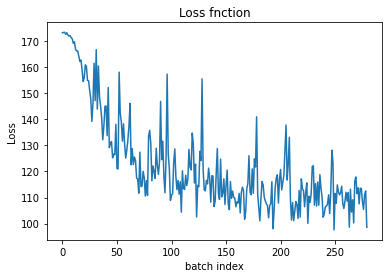

In [40]:
plot_loss(losses)

## Smoothened out losses by averaging

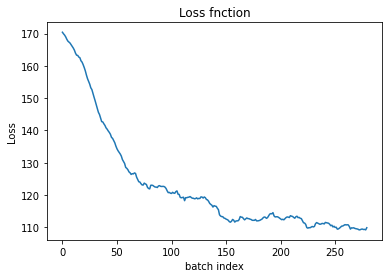

In [46]:
smooth_loss(losses,15)

## Validation dataset losses 

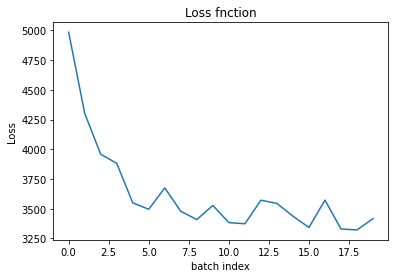

In [42]:
plot_loss(valid_losses)

## Smoothened out validation dataset losses

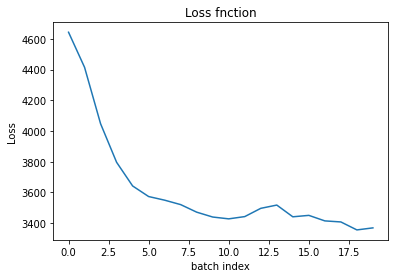

In [43]:
smooth_loss(valid_losses,1)

## Using our model to classify a few sentences.

The output is closer to 1 for a positive sentence <br>
The output is closer to 0 for a negative sentence

In [69]:
def classify(sentence):
  ret = preprocess_text(sentence)
  ret = make_tokens(ret)
  ret = make_bow_vector(review_dict,ret)
  preds = list(FFNN(ret))
  return preds[0][1].item()

In [70]:
classify('Worst thing ever watched')

0.024697815999388695

In [71]:
classify('A must watch')

0.4729979634284973

In [72]:
classify('Worth your money')

0.2434225082397461

In [73]:
classify('Excellent product')

0.9210341572761536

In [84]:
classify('Among worst. Dont waste your time.')

0.008470557630062103

In [85]:
classify('Among worst works of director Snyder')

0.030414214357733727

In [87]:
classify('Fury did outdid himself this time')

0.5453313589096069